In [45]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# import pygame as pg
from scipy.spatial import Delaunay
import time
# from HalfEdge import *
from geompreds import orient2d, incircle
import gmsh
import sys
from bisect import bisect

In [53]:
class TriangularMesh:
    def __init__(self, vertices=[], faces=[], halfedges=[]):
        self.vertices = vertices
        self.faces = faces
        self.halfedges = halfedges
        self.version = int(sys.version.split('.')[1]) >= 10
    
    def add_Hvertex(self, coords, halfedge, Hilbert, index=None):
        if self.version:
            ind = bisect(self.vertices, Vertex(Hilbert=Hilbert), key=lambda x: x.Hilbert)
            self.vertices.insert(ind, Vertex(coords, halfedge, Hilbert, index))
        else:
            self.vertices.append(Vertex(coords, halfedge, Hilbert, index))
            self.vertices.sort(key=lambda x: x.Hilbert)
            ind = self.vertices.index(Vertex(coords, halfedge, Hilbert, index))
        return ind
    
    def add_Hvertices(self, vertices):
        self.vertices += vertices
        self.vertices.sort(key=lambda x: x.Hilbert)
        return list(filter(lambda i: self.vertices[i] in vertices, range(len(self.vertices))))
    
    def add_mesh(self, mesh):
        self.vertices += mesh.vertices
        self.vertices.sort(key=lambda x: x.Hilbert)
        self.faces += mesh.faces
        self.halfedges += mesh.halfedges

    def rem_mesh(self, mesh):
        self.vertices = list(filter(lambda v: v not in mesh.vertices, self.vertices))
        self.faces = list(filter(lambda f: f not in mesh.faces, self.faces))
        self.halfedges = list(filter(lambda h: h not in mesh.halfedges, self.halfedges))
    
class Vertex:
    def __init__(self, coords=None, halfedge=None, Hilbert=None, next=None, prev=None, index=None):
        self.coords = coords
        self.halfedge = halfedge
        self.Hilbert = Hilbert
        self.next = next
        self.prev = prev
        self.index = index

class Face:
    def __init__(self, halfedge=None, visited=False, index=None):
        self.halfedge = halfedge # halfedge going ccw around this facet
        self.visited = visited
        self.index = index

class Halfedge:
    def __init__(self, next=None, prev=None, twin=None, vertex=None, facet=None, index=None):
        self.next = next
        self.prev = prev
        self.twin = twin
        self.vertex = vertex
        self.facet = facet
        self.index = index

In [11]:
arr = [np.random.rand(2) for i in range(10000000)]

In [13]:
%timeit arr2 = list(map(lambda x: (x[0], x[1]), arr))

4.08 s ± 1.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit list(map(tuple, arr))
orient2d()

12 s ± 1.86 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
input_file = 'pts.dat' if '-i' not in sys.argv else sys.argv[sys.argv.index('-i') + 1]
output_file = 'triangles.dat' if '-o' not in sys.argv else sys.argv[sys.argv.index('-o') + 1]

In [23]:
points = np.random.rand(2, 10).T if input_file == '' else np.loadtxt(input_file, skiprows=1)
N = len(points)
border = [min(points[:, 0]), max(points[:, 0]), min(points[:, 1]), max(points[:, 1])]

Time: 0.0019779205322265625


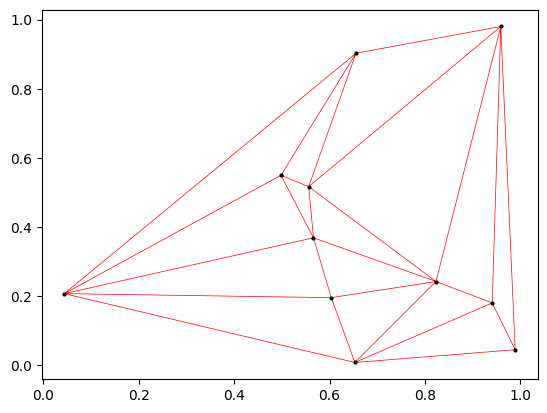

In [52]:
# expected result
start = time.time()
tri = Delaunay(points)
print('Time:', time.time() - start)
plt.triplot(points[:,0], points[:,1], tri.simplices, 'r-', linewidth=0.5)
plt.plot(points[:,0], points[:,1], 'ko', markersize=2)
plt.show()

In [47]:
depth = 8
def Hilbert(point, depth, O, R, B):
    point, O, R, B = map(np.array, [point, O, R, B])
    index = [0] * depth
    for i in range(depth):
        dotR = np.dot(point-O, R) > 0.
        dotB = np.dot(point-O, B) > 0.
        R /= 2.
        B /= 2.
        if dotR:
            if dotB:
                index[i] = 2
                O += R + B
            else:
                index[i] = 3
                O += R - B
                R, B = B, R
        else:
            if dotB:
                index[i] = 1
                O -= R - B
            else:
                index[i] = 0
                O -= R + B
                R, B = B, R
    return index

In [51]:
a = (0.79,0.15)
res = Hilbert(a, 8, (0.5, 0.5), (0.5, 0), (0, 0.5))
print(res)

[3, 1, 3, 0, 1, 3, 2, 0]


In [7]:
# sort points according to Hilbert curve

In [8]:
def Ball(cavity, p, index):
    # connect p to all vertices of the cavity
    new_mesh = TriangularMesh()
    new_mesh.vertices = cavity.vertices + [p]
    prev_edge1 = None
    for edge in cavity.halfedges:
        edge1, edge2, face = Halfedge(), Halfedge(), Face()
        edge1.vertex = p
        edge1.next = edge
        edge1.opposite = edge2
        edge1.facet = face
        edge1.index = index
        edge2.vertex = edge.vertex
        edge2.previous = edge.previous
        edge2.opposite = edge1
        edge2.facet = face
        edge2.index = index + 1
        edge2.next = prev_edge1
        prev_edge1 = edge1
        face.halfedge = edge
        face.index = index + 2
        index += 3
        new_mesh.halfedges += [edge1, edge2]
        new_mesh.faces.append(face)
        new_mesh.halfedges[1].next = new_mesh.halfedges[-2]
    return new_mesh

In [56]:
incircle((0, 0), (1, 0), (0, 1), (0.5, 0.5))

0.5

In [88]:
a, b, c = (2., 3.), (np.inf, -np.inf), (np.inf, np.inf)
sum(map(lambda x: (np.array(x)>0) * np.isinf(x), [a, b, c]))
tuple(map(lambda x: (np.array(x)>0) * np.isinf(x), [a, b, c]))
tuple(sum(x) for x in zip(a, b, c))
%timeit next(filter(lambda x: not np.isinf(x[0]), (a,b,c)))

1.24 μs ± 86.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [70]:
bool(np.array([2, 1]) == )

SyntaxError: invalid syntax (3933556002.py, line 1)

In [90]:
from collections import deque
def Cavity(mesh, p, ind):
    visited = []
    # find a triangle containing p
    def check_triangle(halfedge):
        if halfedge.facet.visited:
            return False
        halfedge.facet.visited = True
        visited.append(halfedge.facet)
        a, b, c = halfedge.vertex.coords, halfedge.next.vertex.coords, halfedge.prev.vertex.coords
        res = incircle(a, b, c, p.coords)
        if np.isnan(res):
            # number of None in [a, b, c]
            k = [halfedge.twin, halfedge.next.twin, halfedge.prev.twin].count(None)
            if k == 1 or k == 3:
                # do orient2d test instead
                return orient2d(a, b, p.coords) >= 0 or orient2d(b, c, p.coords) >= 0 or orient2d(c, a, p.coords) >= 0
            elif k == 2:
                # find index of non infinite point in [a, b, c]
                d = a if not np.isinf(a[0]) else b if not np.isinf(b[0]) else c
                hello = tuple(sum(x) for x in zip(a, b, c))
                if np.isnan(hello[1]):
                    return p.coords[0] >= d.coords[0] if hello[0] > 0 else p.coords[0] <= d.coords[0]
                else:
                    return p.coords[1] >= d.coords[1] if hello[1] > 0 else p.coords[1] <= d.coords[1]

        return res >= 0

    def check_vertex(vertex):
        halfedge = vertex.halfedge
        while True:
            if check_triangle(halfedge):
                return halfedge
            halfedge = halfedge.twin.next
            if halfedge == vertex.halfedge or halfedge == None:
                break
        return None
    
    i = 2
    while True:
        u = mesh.vertices[ind + (-1)**i * i // 2]
        ok_tr = check_vertex(u)
        if ok_tr:
            break
        i += 1
    
    def expand(halfedge):
        res = TriangularMesh(vertices=[halfedge.vertex, halfedge.next.vertex, halfedge.prev.vertex], faces=[halfedge.facet], halfedges=[halfedge, halfedge.next, halfedge.prev])
        stack = deque([halfedge.twin, halfedge.next.twin, halfedge.prev.twin])
        while stack:
            edge = stack.popleft()
            if not check_triangle(edge):
                continue
            edge.facet.visited = True
            visited.append(edge.facet)
            res.vertices.append(edge.prev.vertex)
            res.halfedges += [edge, edge.next, edge.prev]
            res.faces.append(edge.facet)

            for e in [edge.next.twin, edge.prev.twin]:
                if e and not e.facet.visited:
                    stack.append(e)
        return res

    return expand(ok_tr)





In [ ]:
def DL(points):
    
    # sort points according to Hilbert curve
    depth = 8
    O = np.array([0.5, 0.5])
    R = np.array([0.5, 0])
    B = np.array([0, 0.5])
    indices = [Hilbert(point, depth, O, R, B) for point in points]
    indices = sorted(range(len(indices)), key=lambda i: indices[i])
    mesh = TriangularMesh()
    # create super triangle
    A = Vertex((border[0] - 1, border[2] - 1))
    B = Vertex((border[1] + 1, border[2] - 1))
    C = Vertex((border[0] + border[1], border[3] + 1))
    super_triangle = Face()
    super_triangle.halfedge = Halfedge(vertex=A, next=Halfedge(vertex=B, next=Halfedge(vertex=C, next=Halfedge(vertex=A, facet=super_triangle))))
    super_triangle.index = 0
    mesh.add_mesh(TriangularMesh(vertices=[A, B, C], faces=[super_triangle], halfedges=[super_triangle.halfedge, super_triangle.halfedge.next, super_triangle.halfedge.next.next, super_triangle.halfedge.next.next.next]))
    for i in indices:
        cavity = Cavity(mesh, Vertex(points[i]), i)
        mesh.add_mesh(Ball(cavity, Vertex(points[i]), i))
    return mesh

In [71]:
orient2d((0., 0.), (0.5, 0.), (np.inf, -0.1))

nan

In [14]:
%timeit incircle(np.array([0., 0.]), np.array([1., 0.]), np.array([0., 1.]), np.array([0.5, -0.1]))

9.95 μs ± 1.3 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
%timeit incircle((0., 0.), (1., 0.), (0., 1.), (0.5, -0.1))

471 ns ± 31.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
def test(a, b, c, p):
    # if one of the points has index -1, do orient2d instead of incircle
    if -1 in [a.index, b.index, c.index]:
        return orient2d(a.coords, b.coords, c.coords)


In [64]:
import math
sys.float_info.max/1e139

1.7976931348623156e+169

In [76]:
%timeit incircle((0., 0.), (1., 0.), (0., 1.0), (0.5, -0.15))

483 ns ± 41.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [78]:
%timeit incircle((np.float64(0.), np.float64(0.)), (np.float64(1.), np.float64(0.)), (np.float64(0.), np.float64(1.0)), (np.float64(0.5), np.float64(-0.15)))

4.16 μs ± 266 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [37]:
a = [(0., 0.), (1., 0.), (0., 1.0), (0.5, -0.15)]
# a = [[0., 0.], [1., 0.], [0., 1.0], [0.5, -0.15]]
# a = [(np.float64(0.), np.float64(0.)), (np.float64(1.), np.float64(0.)), (np.float64(0.), np.float64(1.0)), (np.float64(0.5), np.float64(-0.15))]
# a = [np.array([0., 0.]), np.array([1., 0.]), np.array([0., 1.0]), np.array([0.5, -0.15])]
# a = np.array([[0., 0.], [1., 0.], [0., 1.0], [0.5, -0.15]])
%timeit incircle(a[0], a[1], a[2], a[3])

392 ns ± 139 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [43]:
arr = np.random.rand(10000000, 2)
%timeit arr2 = list(map(tuple, arr.tolist()))

2.94 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([0., 0.])

In [81]:
%timeit incircle((np.float32(0.), np.float32(0.)), (np.float32(1.), np.float32(0.)), (np.float32(0.), np.float32(1.0)), (np.float32(0.5), np.float32(-0.15)))

13.1 μs ± 1.2 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [82]:
%timeit incircle((np.float16(0.), np.float16(0.)), (np.float16(1.), np.float16(0.)), (np.float16(0.), np.float16(1.0)), (np.float16(0.5), np.float16(-0.15)))

13.3 μs ± 1.96 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
%timeit incircle([0., 0.], [1., 0.], [0., 1.], [0.5, -0.1])

1.04 μs ± 164 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [83]:
a = list(map(tuple, np.random.rand(2, 10).T))

In [84]:
%timeit incircle(a[0], a[1], a[2], a[3])

1.19 μs ± 239 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
points

In [ ]:
np.random.rand(10, 2)

In [31]:
b = sorted(np.random.rand(100, 2), key=lambda x: Hilbert(x, depth, np.array([0.5, 0.5]), np.array([0.5, 0.]), np.array([0., 0.5])))

In [32]:
insort(b, np.array([0.51, 0.49]), key=lambda x: Hilbert(x, depth, np.array([0.5, 0.5]), np.array([0.5, 0.]), np.array([0., 0.5])))

In [ ]:
for i, p in enumerate(b):
    plt.plot(p[0], p[1], 'ko')
    # write index
    plt.text(p[0], p[1], str(i))
plt.plot(b[-1][0], b[-1][1], 'ro')
plt.show()


In [10]:
class test:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    def __repr__(self):
        return str(self.a-self.b)

l = [] 
for i in range(10):
    l.append(test(4*i**2, 3*i))

print(l[3].b)

9
